In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

N=500
num_bins=20

# I. Monte-Carlo for some multiplicative free convolutions.

## I. 1. White case

$$ \frac{1}{2 \pi} \frac{\sqrt{(x-l)(r-x)}}{x} dx ,$$
where 
$$r = (1+\sqrt{c})^2$$
$$l = (1-\sqrt{c})^2$$
and $c$ being the scale parameter.



 Shape of Wishart:  (150, 150)


/tmp/ipykernel_55437/1272017483.py:16: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins*c) # Added extra c. I believe this is the c part of the mass, while (1-c) is a Dirac at zero


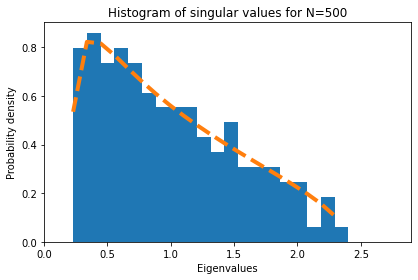

In [4]:
c = 0.3
p = int(c*N)
r = (1+np.sqrt(c))**2 #Right end
l = (1-np.sqrt(c))**2 #Left end

G = np.random.normal( size=(p, N) )
W = G.dot( G.T )
print(" Shape of Wishart: ", W.shape)
W = W/N
diag, U = np.linalg.eig(W)
diag = 1.0*np.sort( diag )

# Histogram of singular values
fig, ax = plt.subplots()
n, bins, patches = ax.hist(diag, num_bins, density=True)
y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins*c) # Added extra c. I believe this is the c part of the mass, while (1-c) is a Dirac at zero
ax.plot(bins, y, '--', linewidth=4)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for N={}'.format(N))
fig.tight_layout()
plt.xlim(0,r+0.5)
plt.show()

## I.2. Three subpopulations

 Shape of Wishart:  (150, 150)


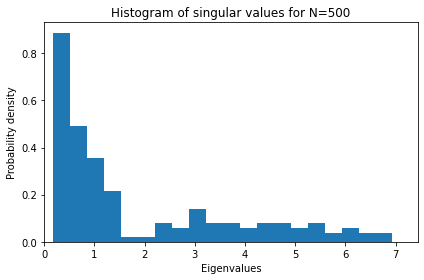

In [5]:
weights = np.array( [1, 1, 1] )
weights = weights/np.sum( weights )
support = np.array( [0.5, 1, 4] )

population_cdf = np.cumsum( weights )

c = 0.3
p = int(c*N)
population_matrix = np.zeros( (p,) )
block_begin = 0
for i in range( len(weights) ):
    block_end = int( population_cdf[i]*p )
    population_matrix[block_begin:block_end] = support[i]
    block_begin = block_end

G = np.random.normal( size=(p, N) )
G = np.dot( np.diag( np.sqrt( population_matrix) ), G)
W = G.dot( G.T )
print(" Shape of Wishart: ", W.shape)
W = W/N
diag, U = np.linalg.eig(W)
diag = 1.0*np.sort( diag )

# Histogram of singular values
fig, ax = plt.subplots()
n, bins, patches = ax.hist(diag, num_bins, density=True)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for N={}'.format(N))
fig.tight_layout()
plt.xlim(0,np.max(diag)+0.5)
plt.show()

# II. Dictionnary build

## II. 1. Following El Karoui: Fix  $\nu_F(z_i)$ and compute $z_i$

Range of eigenvalues:  0.17143493486366462 6.935320820423748


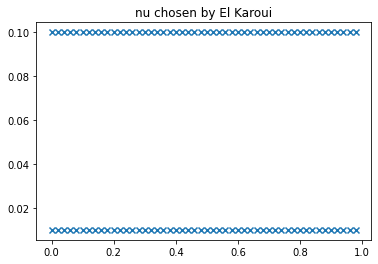

In [6]:
nu = np.array( [complex(0.02*a,b) for a in range(0, 50) for b in [0.01,0.1]] )

l1 = np.max( diag )
lp = np.min( diag )
print( "Range of eigenvalues: ", lp, l1)

plt.figure()
plt.scatter( np.real(nu), np.imag(nu), marker='x')
plt.title("nu chosen by El Karoui")
plt.show()

diag_norm = diag/l1

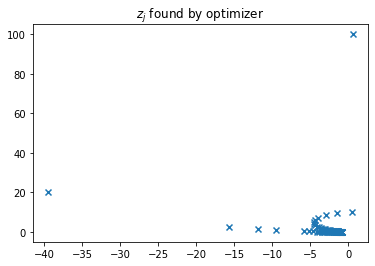

In [9]:
# Solve using inversion package
import scipy.optimize as opt

Z=[]
for k in range(len(nu)):
    def f(z):
        z = complex(z[0],z[1])
        stieljes   = np.sum(1/(diag-z))/len(diag)
        expression = -(1-c)/z + c*stieljes - nu[k]
        return((re(expression),im(expression)))
    (r,i) = opt.fsolve(f,(1,1))
    z = complex(r,i)
    Z.append(z)
Z = np.array( Z )
#
plt.figure()
plt.scatter( np.real(Z), np.imag(Z), marker='x')
plt.title("$z_j$ found by optimizer")
plt.show()

In [10]:
# Check that optimization worked
def stieltjes_check(z_array):
    array = z_array[...,None]-diag[...,:]
    return np.sum( -1/array, axis=-1)/len(diag)

nu_check = -(1-c)/Z + c*stieltjes_check(Z)
nu_errors = np.abs(nu - nu_check)
bad_indices = np.where(nu_errors > 1e-5)[0]
print( "Bad indices:", bad_indices )
print( "Values     :", nu[bad_indices] )
print( "Max error  :", np.max(nu_errors) )
print( "" )

# Clean-up if necessary
if len(bad_indices):
    print("Removing bad indices...")
    Z  = np.delete( Z , bad_indices )
    nu = np.delete( nu, bad_indices)

Bad indices: []
Values     : []
Max error  : 3.601786000121454e-11



In [11]:
dictionary = (Z, nu)

## II.2. Fix $z_j$ and deduce $\nu(z_j)$

In [13]:
def stieltjes(z_array):
    array = z_array[...,None]-diag[...,:]
    return np.sum( -1/array, axis=-1)/len(diag)

In [14]:
#Z = np.linspace(0.1, 1, 100) + (1e-2)*1.0j
#plt.scatter( np.real(Z), np.imag(Z), marker='x')
#plt.title("Z")
#plt.show()

#nu = c*stieltjes(Z) - (1-c)*1/Z
#plt.figure()
#plt.scatter( np.real(nu), np.imag(nu), marker='x')
#plt.title("nu")
#plt.show()


In [15]:
#errors = []
#c_interval = np.linspace( 0.1, 3, 100)
#for c in c_interval:
#  error = np.linalg.norm(1/nu + Z - c*1/(1+nu))/len(Z)
#  errors.append( error )
#errors = np.array( errors )

#plt.plot( c_interval, errors)
#plt.title("Errors as a function of c")
#plt.ylim( (0, np.max(errors)))
#plt.show()


In [16]:
#errors = []
#pos_interval = np.linspace( 0.1, 3, 100)
#for t in pos_interval:
#  error = np.linalg.norm(1/nu + Z - (1/c)*t/(1+t*nu))/len(Z)
#  errors.append( error )
#errors = np.array( errors )

#plt.plot( pos_interval, errors)
#plt.title("Errors as a function of c")
#plt.ylim( (0, np.max(errors)))
#plt.show()

# III. Convex optimization

In [17]:
import cvxpy as cp

def perform_cvx_optimization( dictionary, T, norm_type):
  Z, nu  = dictionary
  assert(len(Z) == len(nu))

  print( "Building cvxpy program..." )
  # Weights
  W = cp.Variable(len(T),complex=False)
  # Contrains
  const=[]

  # Form array of errors e_j's
  e_array = []
  for i in range(len(nu)):
      # Does not work
      # e = 1/nu[i] + Z[i] - c*sum([T[j]*W[j]/(1+T[j]*nu[i]) for j in range(len(T)) ])
      # Strangely works ==> cvxpy has a bad overloading of operators * / + - ?
      integrand = T/(1+T*nu[i])
      summand   = [ W[j]*integrand[j] for j in range(len(T)) ]
      e_j = 1/nu[i] + Z[i] - c*sum(summand)
      e_array.append( e_j )

  if norm_type=='linfty':
    # Mute variable for minimization
    u = cp.Variable(1)
    objective= cp.Minimize(u)
    for e in e_array:
        const.append(cp.real(e)<=u)
        const.append(cp.real(e)>=-u)
        const.append(cp.imag(e)<=u)
        const.append(cp.imag(e)>=-u)
    # end for
  elif norm_type=='l1':
    e = sum( [ cp.abs(e_j) for e_j in e_array ] )/len(e_array)
    objective= cp.Minimize(e)
  elif norm_type=='l2':
    # Accumulate error
    e=0
    e_array = []
    for i in range(len(nu)):
        # Does not work
        # e = 1/nu[i] + Z[i] - c*sum([T[j]*W[j]/(1+T[j]*nu[i]) for j in range(len(T)) ])
        # Strangely works ==> cvxpy has a bad overloading of operators * / + - ?
        integrand = T/(1+T*nu[i])
        summand   = [ W[j]*integrand[j] for j in range(len(T)) ]
        e_j = 1/nu[i] + Z[i] - c*sum(summand)
        e += cp.abs( e_j*cp.conj( e_j ) )
    # end for
    objective= cp.Minimize(e)

  # Final constrains
  const.append(W>=0)
  const.append(sum(W)==1)

  print( "Solving the convex problem...")
  problem = cp.Problem(objective, const)
  result  = problem.solve(verbose=True)

  return W.value, objective.value


In [24]:
import cvxpy as cp

def perform_cvx_optimization( dictionary, T, norm_type):
  Z, nu  = dictionary
  assert(len(Z) == len(nu))

  print( "Building cvxpy program..." )
  # Weights
  W = cp.Variable(len(T),complex=False)
  # Constrains
  const=[]

  # Form array of errors e_j's
  e_array = []
  for i in range(len(nu)):
      # Does not work
      # e = 1/nu[i] + Z[i] - c*sum([T[j]*W[j]/(1+T[j]*nu[i]) for j in range(len(T)) ])
      # Strangely works ==> cvxpy has a bad overloading of operators * / + - ?
      integrand = T/(1+T*nu[i])
      summand   = [ W[j]*integrand[j] for j in range(len(T)) ]
      e_i = 1/nu[i] + Z[i] - c*sum(summand)
      e_array.append( e_i )
  e_vector = cp.bmat( [e_array] )

  # Form objective
  if norm_type=='linfty':
    # Mute variable for minimization
    u = cp.Variable(1)
    objective= cp.Minimize(u)
    for e in e_array:
        const.append(cp.real(e)<=u)
        const.append(cp.real(e)>=-u)
        const.append(cp.imag(e)<=u)
        const.append(cp.imag(e)>=-u)
    # end for
  elif norm_type=='l1':
    #e = sum( [ cp.abs(e_j) for e_j in e_array ] )/len(nu)
    e = cp.norm1( e_vector )/len(nu)
    objective = cp.Minimize(e)
  elif norm_type=='l2':
    e = cp.norm2( cp.abs(e_vector) )/np.sqrt( len(nu) )
    objective = cp.Minimize(e)

  # Final constrains
  const.append(W>=0)
  const.append(sum(W)==1)

  print( "Solving the convex problem...")
  problem = cp.Problem(objective, const)
  result  = problem.solve(verbose=True)

  return W.value, objective.value

## III. 1. $l^\infty$ norm

Building cvxpy program...
Solving the convex problem...
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 06 09:39:20 PM: Your problem has 201 variables, 386 constraints, and 0 parameters.
(CVXPY) Aug 06 09:39:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 06 09:39:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 06 09:39:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 06 09:39:21 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 06 09:39:21 PM: Reduction

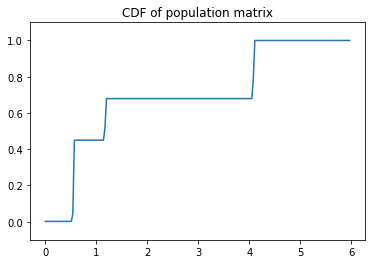

In [25]:
# Support
T = np.arange(0, 6, 0.03)
# Perform optimization
weights, objective_value = perform_cvx_optimization( dictionary, T, 'linfty')
# Plots
print("Found objective value: ", objective_value)
plt.figure()
plt.plot( T,np.cumsum(weights))
plt.title("CDF of population matrix")
plt.ylim( (-0.1,1.1) )
plt.show()


## III. 2. $l^1$ norm

Building cvxpy program...
Solving the convex problem...
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 06 09:39:36 PM: Your problem has 200 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 06 09:39:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 06 09:39:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 06 09:39:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 06 09:39:37 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 06 09:39:37 PM: Reduction c

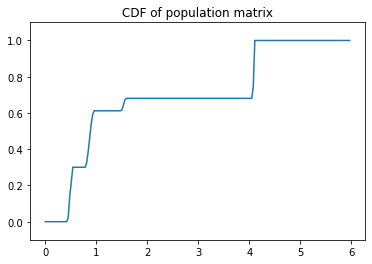

In [26]:
# Support
T = np.arange(0, 6, 0.03)
# Perform optimization
weights, objective_value = perform_cvx_optimization( dictionary, T, 'l1')
# Plots
print("Found objective value: ", objective_value)
plt.figure()
plt.plot( T,np.cumsum(weights))
plt.title("CDF of population matrix")
plt.ylim( (-0.1,1.1) )
plt.show()

## III. 3. $l^2$ norm

Building cvxpy program...
Solving the convex problem...
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 06 09:39:46 PM: Your problem has 200 variables, 2 constraints, and 0 parameters.
(CVXPY) Aug 06 09:39:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 06 09:39:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 06 09:39:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 06 09:39:47 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 06 09:39:47 PM: Reduction c

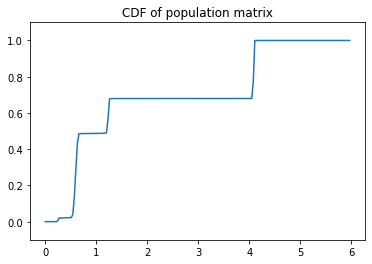

In [27]:
# Support
T = np.arange(0, 6, 0.03)
# Perform optimization
weights, objective_value = perform_cvx_optimization( dictionary, T, 'l2')
# Plots
print("Found objective value: ", objective_value)
plt.figure()
plt.plot( T,np.cumsum(weights))
plt.title("CDF of population matrix")
plt.ylim( (-0.1,1.1) )
plt.show()